In [142]:
%matplotlib inline
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import struct
import numpy as np
import argparse
from open3d import *
import pickle
import matplotlib as mpl
import numpy as np
import math
#def clockwise(points):
#    x = points[:,0]
#    y = points[:,1]
#    cx = np.mean(x)
#    cy = np.mean(y)
#    a = np.arctan2(y - cy, x - cx)
#    order = a.ravel().argsort()
#    x = x[order]
#    y = y[order]
#    return np.vstack([x,y])

def in_between(p, a0, a1):
    # check whether p is in between a0 and a1
    # by solving p = a0 + alpha * (a1 - a0)
    dif, t = p - a0, a1 - a0
    # then dif = alpha * t
    # then |alpha| = ||dif|| / ||t||
    alpha = np.linalg.norm(dif) / np.linalg.norm(t)
    # alpha * t = +- dif
    d1 = sum(alpha * t + dif)
    d2 = sum(alpha * t - dif)
    if alpha >= 0. and alpha <= 1. and (d1 == 0. or d2 == 0.):
        return True
    return False
    
def line_intersect(a0, a1, b0, b1):
    x1 = a1[1] - a0[1]
    y1 = a0[0] - a1[0]
    c1 = a1[0] * a0[1] - a0[0] * a1[1]
    r3 = x1 * b0[0] + y1 * b0[1] + c1
    r4 = x1 * b1[0] + y1 * b1[1] + c1
    if r3 * r4 > 0:
        return False
    x2 = b1[1] - b0[1]
    y2 = b0[0] - b1[0]
    c2 = b1[0] * b0[1] - b0[0] * b1[1]
    r1 = x2 * a0[0] + y2 * a0[1] + c2
    r2 = x2 * a1[0] + y2 * a1[1] + c2
    if r1 * r2 > 0:
        return False
    denom = x1 * y2 - x2 * y1
    if denom == 0.:
        return False  # collinear
    return True
"""
def line_intersect(a0,a1,b0,b1):
    # given one line [a0,a1], one line [b0,b1], decide whether they intersect
    # l1: x = a0 + alpha * (a1-a0)  for alpha in [0,1]
    # l2: x = b0 + beta * (b1-b0)   for beta in [0,1]
    # obtaining system: a0 + alpha * (a1 - a0) = b0 + beta * (b1 - b0)
    # hence (alpha, beta) = [-(a1-a0), b1-b0]^{-1} (a0 - b0)
    # Notice that matrix [-(a1-a0), b1-b0] should be invertible
    # if it is not, then the two lines are parallel
    # then if there is one vertex in the line segment between the other
    # collide
    
    # varaible recording difference
    t1, t2 = a1 - a0, b1 - b0
    mat = np.array([-t1, t2]).T  # np array saves as row vectors, but we want col
    # check if det is 0
    if np.linalg.det(mat) == 0:
        # parallel line, need to check whether they collide
        # by checking if each point is in the other line
        if in_between(a0,b0,b1):
            return True
        if in_between(a1,b0,b1):
            return True
        if in_between(b0,a0,a1):
            return True
        if in_between(b1,a0,a1):
            return True
        # otherwise parallel but no collision
        return False
    # otherwise, obtain [alpha, beta]
    sol = np.linalg.inv(mat) @ (a0 - b0)
    # if colllision point is in both lines
    if sol[0] >= 0 and sol[0] <= 1 and sol[1] >= 0 and sol[1] <= 1:
        return True
    return False
"""
def IsInCollision(stateIn,obc):
    size = 5.
    robot_corner=np.zeros((4,2),dtype=np.float32)
    robot_axis=np.zeros((2,2),dtype=np.float32)
    robot_orign=np.zeros(2,dtype=np.float32)
    length=np.zeros(2,dtype=np.float32)
    X1=np.zeros(2,dtype=np.float32)
    Y1=np.zeros(2,dtype=np.float32)

    X1[0]=math.cos(stateIn[2])*(2.0/2.0)
    X1[1]=-math.sin(stateIn[2])*(2.0/2.0)
    Y1[0]=math.sin(stateIn[2])*(5.0/2.0)
    Y1[1]=math.cos(stateIn[2])*(5.0/2.0)
    for j in range(0,2):
        robot_corner[0][j]=stateIn[j]-X1[j]-Y1[j]
        robot_corner[1][j]=stateIn[j]+X1[j]-Y1[j]
        robot_corner[2][j]=stateIn[j]+X1[j]+Y1[j]
        robot_corner[3][j]=stateIn[j]-X1[j]+Y1[j]

        robot_axis[0][j] = robot_corner[1][j] - robot_corner[0][j]
        robot_axis[1][j] = robot_corner[3][j] - robot_corner[0][j]

    length[0]=robot_axis[0][0]*robot_axis[0][0]+robot_axis[0][1]*robot_axis[0][1]
    length[1]=robot_axis[1][0]*robot_axis[1][0]+robot_axis[1][1]*robot_axis[1][1]
    for i in range(0,4):
        pass
    for i in range(0,2):
        for j in range(0,2):
            robot_axis[i][j]=robot_axis[i][j]/float(length[j])

    robot_orign[0]=robot_corner[0][0]*robot_axis[0][0]+ robot_corner[0][1]*robot_axis[0][1]
    robot_orign[1]=robot_corner[0][0]*robot_axis[1][0]+ robot_corner[0][1]*robot_axis[1][1]

    for i in range(0,1):
        cf=True

        obs_corner=np.zeros((4,2),dtype=np.float32)
        obs_axis=np.zeros((2,2),dtype=np.float32)
        obs_orign=np.zeros(2,dtype=np.float32)
        X=np.zeros(2,dtype=np.float32)
        Y=np.zeros(2,dtype=np.float32)
        length2=np.zeros(2,dtype=np.float32)

        X[0]=1.0*size/2.0
        X[1]=0.0
        Y[0]=0.0
        Y[1]=1.0*size/2.0

        for j in range(0,2):
            obs_corner[0][j]=obc[i][j]-X[j]-Y[j]
            obs_corner[1][j]=obc[i][j]+X[j]-Y[j]
            obs_corner[2][j]=obc[i][j]+X[j]+Y[j]
            obs_corner[3][j]=obc[i][j]-X[j]+Y[j]

            obs_axis[0][j] = obs_corner[1][j] - obs_corner[0][j]
            obs_axis[1][j] = obs_corner[3][j] - obs_corner[0][j]

        length2[0]=obs_axis[0][0]*obs_axis[0][0]+obs_axis[0][1]*obs_axis[0][1]
        length2[1]=obs_axis[1][0]*obs_axis[1][0]+obs_axis[1][1]*obs_axis[1][1]

        for i1 in range(0,2):
            for j1 in range(0,2):
                obs_axis[i1][j1]=obs_axis[i1][j1]/float(length2[j1])


        obs_orign[0]=obs_corner[0][0]*obs_axis[0][0]+ obs_corner[0][1]*obs_axis[0][1]
        obs_orign[1]=obs_corner[0][0]*obs_axis[1][0]+ obs_corner[0][1]*obs_axis[1][1]
        for i in range(-1,len(robot_corner)-1):
            for j in range(-1,len(obs_corner)-1):
                if line_intersect(robot_corner[i], robot_corner[i+1], obs_corner[j], obs_corner[j+1]):
                    # if any two lines intersect, then collision
                    return True
    return False


collision detection time: 0.000229
True


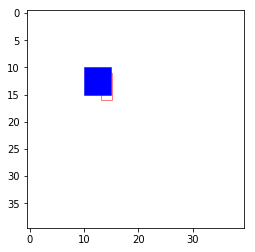

In [143]:
import time
im = np.ones((40,40,3))

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Create a Rectangle patch
robot_origin = [14.1,13.5]
r1 = patches.Rectangle((robot_origin[0]-2/2,robot_origin[1]-5/2),2,5,linewidth=.5,edgecolor='r',facecolor='none')
# rotate clockwisely
# pose: alpha
alpha = 0
t = mpl.transforms.Affine2D().rotate_deg_around(robot_origin[0], robot_origin[1], alpha) + ax.transData
r1.set_transform(t)
# Add the patch to the Axes
ax.add_patch(r1)
pt = [(2.5*5.,2.5*5), (2.*5.,0.), (2.5*5.,2.5*5), (0.,2.5*5), (2.7*2.5,2.*5),(5*2.5,9*2.5),(9*2.5,10*2.5)]
for i in range(1):
    pt_i = (pt[i][0]-5./2, pt[i][1]-5./2)
    ri = patches.Rectangle(pt_i,5.,5.,linewidth=.5,edgecolor='b',facecolor='b')
    ax.add_patch(ri)

r1_state = np.array(robot_origin + [-alpha/180*np.pi])
obc = np.array([[2.5*5.,2.5*5]])
start = time.time()
cf = IsInCollision(r1_state, obc)
print('collision detection time: %f' % (time.time()-start))
print(cf)
def draw_polygon(coord):
    coord = coord.tolist()
    coord.append(coord[0])
    xs, ys = zip(*coord) #create lists of x and y values
    ax.plot(xs,ys)
plt.show()

In [144]:

def line_intersect(a0,a1,b0,b1):
    # given one line [a0,a1], one line [b0,b1], decide whether they intersect
    # l1: x = a0 + alpha * (a1-a0)  for alpha in [0,1]
    # l2: x = b0 + beta * (b1-b0)   for beta in [0,1]
    # obtaining system: a0 + alpha * (a1 - a0) = b0 + beta * (b1 - b0)
    # hence (alpha, beta) = [-(a1-a0), b1-b0]^{-1} (a0 - b0)
    # Notice that matrix [-(a1-a0), b1-b0] should be invertible
    # if it is not, then the two lines are parallel
    # then if there is one vertex in the line segment between the other
    # collide
    
    # varaible recording difference
    t1, t2 = a1 - a0, b1 - b0
    mat = np.array([-t1, t2]).T  # np array saves as row vectors, but we want col
    # check if det is 0
    if np.linalg.det(mat) == 0:
        # parallel line, need to check whether they collide
        # by checking if each point is in the other line
        if in_between(a0,b0,b1):
            return True
        if in_between(a1,b0,b1):
            return True
        if in_between(b0,a0,a1):
            return True
        if in_between(b1,a0,a1):
            return True
        # otherwise parallel but no collision
        return False
    # otherwise, obtain [alpha, beta]
    sol = np.linalg.inv(mat) @ (a0 - b0)
    # if colllision point is in both lines
    if sol[0] >= 0 and sol[0] <= 1 and sol[1] >= 0 and sol[1] <= 1:
        return True
    return False

def IsInCollision(stateIn,obc):
    size = 5.
    robot_corner=np.zeros((4,2),dtype=np.float32)
    robot_axis=np.zeros((2,2),dtype=np.float32)
    robot_orign=np.zeros(2,dtype=np.float32)
    length=np.zeros(2,dtype=np.float32)
    X1=np.zeros(2,dtype=np.float32)
    Y1=np.zeros(2,dtype=np.float32)

    X1[0]=math.cos(stateIn[2])*(2.0/2.0)
    X1[1]=-math.sin(stateIn[2])*(2.0/2.0)
    Y1[0]=math.sin(stateIn[2])*(5.0/2.0)
    Y1[1]=math.cos(stateIn[2])*(5.0/2.0)
    for j in range(0,2):
        robot_corner[0][j]=stateIn[j]-X1[j]-Y1[j]
        robot_corner[1][j]=stateIn[j]+X1[j]-Y1[j]
        robot_corner[2][j]=stateIn[j]+X1[j]+Y1[j]
        robot_corner[3][j]=stateIn[j]-X1[j]+Y1[j]

        robot_axis[0][j] = robot_corner[1][j] - robot_corner[0][j]
        robot_axis[1][j] = robot_corner[3][j] - robot_corner[0][j]

    length[0]=robot_axis[0][0]*robot_axis[0][0]+robot_axis[0][1]*robot_axis[0][1]
    length[1]=robot_axis[1][0]*robot_axis[1][0]+robot_axis[1][1]*robot_axis[1][1]
    for i in range(0,4):
        pass
    for i in range(0,2):
        for j in range(0,2):
            robot_axis[i][j]=robot_axis[i][j]/float(length[j])

    robot_orign[0]=robot_corner[0][0]*robot_axis[0][0]+ robot_corner[0][1]*robot_axis[0][1]
    robot_orign[1]=robot_corner[0][0]*robot_axis[1][0]+ robot_corner[0][1]*robot_axis[1][1]

    for i in range(0,1):
        cf=True

        obs_corner=np.zeros((4,2),dtype=np.float32)
        obs_axis=np.zeros((2,2),dtype=np.float32)
        obs_orign=np.zeros(2,dtype=np.float32)
        X=np.zeros(2,dtype=np.float32)
        Y=np.zeros(2,dtype=np.float32)
        length2=np.zeros(2,dtype=np.float32)

        X[0]=1.0*size/2.0
        X[1]=0.0
        Y[0]=0.0
        Y[1]=1.0*size/2.0

        for j in range(0,2):
            obs_corner[0][j]=obc[i][j]-X[j]-Y[j]
            obs_corner[1][j]=obc[i][j]+X[j]-Y[j]
            obs_corner[2][j]=obc[i][j]+X[j]+Y[j]
            obs_corner[3][j]=obc[i][j]-X[j]+Y[j]

            obs_axis[0][j] = obs_corner[1][j] - obs_corner[0][j]
            obs_axis[1][j] = obs_corner[3][j] - obs_corner[0][j]

        length2[0]=obs_axis[0][0]*obs_axis[0][0]+obs_axis[0][1]*obs_axis[0][1]
        length2[1]=obs_axis[1][0]*obs_axis[1][0]+obs_axis[1][1]*obs_axis[1][1]

        for i1 in range(0,2):
            for j1 in range(0,2):
                obs_axis[i1][j1]=obs_axis[i1][j1]/float(length2[j1])


        obs_orign[0]=obs_corner[0][0]*obs_axis[0][0]+ obs_corner[0][1]*obs_axis[0][1]
        obs_orign[1]=obs_corner[0][0]*obs_axis[1][0]+ obs_corner[0][1]*obs_axis[1][1]
        for i in range(-1,len(robot_corner)-1):
            for j in range(-1,len(obs_corner)-1):
                if line_intersect(robot_corner[i], robot_corner[i+1], obs_corner[j], obs_corner[j+1]):
                    # if any two lines intersect, then collision
                    return True
    return False


collision detection time: 0.000822
True


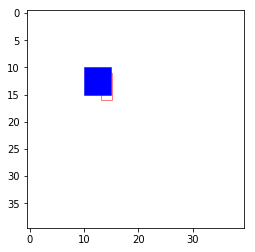

In [145]:
import time
im = np.ones((40,40,3))

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Create a Rectangle patch
robot_origin = [14.1,13.5]
r1 = patches.Rectangle((robot_origin[0]-2/2,robot_origin[1]-5/2),2,5,linewidth=.5,edgecolor='r',facecolor='none')
# rotate clockwisely
# pose: alpha
alpha = 0
t = mpl.transforms.Affine2D().rotate_deg_around(robot_origin[0], robot_origin[1], alpha) + ax.transData
r1.set_transform(t)
# Add the patch to the Axes
ax.add_patch(r1)
pt = [(2.5*5.,2.5*5), (2.*5.,0.), (2.5*5.,2.5*5), (0.,2.5*5), (2.7*2.5,2.*5),(5*2.5,9*2.5),(9*2.5,10*2.5)]
for i in range(1):
    pt_i = (pt[i][0]-5./2, pt[i][1]-5./2)
    ri = patches.Rectangle(pt_i,5.,5.,linewidth=.5,edgecolor='b',facecolor='b')
    ax.add_patch(ri)

r1_state = np.array(robot_origin + [-alpha/180*np.pi])
obc = np.array([[2.5*5.,2.5*5]])
start = time.time()
cf = IsInCollision(r1_state, obc)
print('collision detection time: %f' % (time.time()-start))
print(cf)
def draw_polygon(coord):
    coord = coord.tolist()
    coord.append(coord[0])
    xs, ys = zip(*coord) #create lists of x and y values
    ax.plot(xs,ys)
plt.show()

In [146]:
def overlap(b1corner,b1axis,b1orign,b2corner,b2axis,b2orign):
    for a in range(0,2):
        t=b1corner[0][0]*b2axis[a][0]+b1corner[0][1]*b2axis[a][1]

        tMin = t
        tMax = t
        for c in range(1,4):
            t = b1corner[c][0]*b2axis[a][0]+b1corner[c][1]*b2axis[a][1]
            if t < tMin:
                tMin = t
            elif t > tMax:
                tMax = t
        if ((tMin > (1+ b2orign[a])) or (tMax < b2orign[a])):
            return False

    return True



def IsInCollision(stateIn,obc):
    size = 5.
    robot_corner=np.zeros((4,2),dtype=np.float32)
    robot_axis=np.zeros((2,2),dtype=np.float32)
    robot_orign=np.zeros(2,dtype=np.float32)
    length=np.zeros(2,dtype=np.float32)
    X1=np.zeros(2,dtype=np.float32)
    Y1=np.zeros(2,dtype=np.float32)

    X1[0]=math.cos(stateIn[2])*(2.0/2.0)
    X1[1]=-math.sin(stateIn[2])*(2.0/2.0)
    Y1[0]=math.sin(stateIn[2])*(5.0/2.0)
    Y1[1]=math.cos(stateIn[2])*(5.0/2.0)

    for j in range(0,2):
        robot_corner[0][j]=stateIn[j]-X1[j]-Y1[j]
        robot_corner[1][j]=stateIn[j]+X1[j]-Y1[j]
        robot_corner[2][j]=stateIn[j]+X1[j]+Y1[j]
        robot_corner[3][j]=stateIn[j]-X1[j]+Y1[j]

        robot_axis[0][j] = robot_corner[1][j] - robot_corner[0][j]
        robot_axis[1][j] = robot_corner[3][j] - robot_corner[0][j]

    length[0]=robot_axis[0][0]*robot_axis[0][0]+robot_axis[0][1]*robot_axis[0][1]
    length[1]=robot_axis[1][0]*robot_axis[1][0]+robot_axis[1][1]*robot_axis[1][1]
    #print "robot cornor"
    for i in range(0,4):
        #print "("+str(robot_corner[i][0])+","+str(robot_corner[i][1])+")"
        pass
    for i in range(0,2):
        for j in range(0,2):
            robot_axis[i][j]=robot_axis[i][j]/float(length[j])

    robot_orign[0]=robot_corner[0][0]*robot_axis[0][0]+ robot_corner[0][1]*robot_axis[0][1]
    robot_orign[1]=robot_corner[0][0]*robot_axis[1][0]+ robot_corner[0][1]*robot_axis[1][1]

    for i in range(0,1):
        cf=True

        obs_corner=np.zeros((4,2),dtype=np.float32)
        obs_axis=np.zeros((2,2),dtype=np.float32)
        obs_orign=np.zeros(2,dtype=np.float32)
        X=np.zeros(2,dtype=np.float32)
        Y=np.zeros(2,dtype=np.float32)
        length2=np.zeros(2,dtype=np.float32)

        X[0]=1.0*size/2.0
        X[1]=0.0
        Y[0]=0.0
        Y[1]=1.0*size/2.0

        for j in range(0,2):
            obs_corner[0][j]=obc[i][j]-X[j]-Y[j]
            obs_corner[1][j]=obc[i][j]+X[j]-Y[j]
            obs_corner[2][j]=obc[i][j]+X[j]+Y[j]
            obs_corner[3][j]=obc[i][j]-X[j]+Y[j]

            obs_axis[0][j] = obs_corner[1][j] - obs_corner[0][j]
            obs_axis[1][j] = obs_corner[3][j] - obs_corner[0][j]

        length2[0]=obs_axis[0][0]*obs_axis[0][0]+obs_axis[0][1]*obs_axis[0][1]
        length2[1]=obs_axis[1][0]*obs_axis[1][0]+obs_axis[1][1]*obs_axis[1][1]

        for i1 in range(0,2):
            for j1 in range(0,2):
                obs_axis[i1][j1]=obs_axis[i1][j1]/float(length2[j1])


        obs_orign[0]=obs_corner[0][0]*obs_axis[0][0]+ obs_corner[0][1]*obs_axis[0][1]
        obs_orign[1]=obs_corner[0][0]*obs_axis[1][0]+ obs_corner[0][1]*obs_axis[1][1]

        cf=overlap(robot_corner,robot_axis,robot_orign,obs_corner,obs_axis,obs_orign)
        if cf==True:
            return True
    return False

collision detection time: 0.000248
True


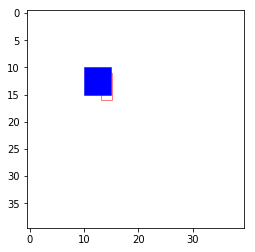

In [147]:
import time
im = np.ones((40,40,3))

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Create a Rectangle patch
robot_origin = [14.1,13.5]
r1 = patches.Rectangle((robot_origin[0]-2/2,robot_origin[1]-5/2),2,5,linewidth=.5,edgecolor='r',facecolor='none')
# rotate clockwisely
# pose: alpha
alpha = 0
t = mpl.transforms.Affine2D().rotate_deg_around(robot_origin[0], robot_origin[1], alpha) + ax.transData
r1.set_transform(t)
# Add the patch to the Axes
ax.add_patch(r1)
pt = [(2.5*5.,2.5*5), (2.*5.,0.), (2.5*5.,2.5*5), (0.,2.5*5), (2.7*2.5,2.*5),(5*2.5,9*2.5),(9*2.5,10*2.5)]
for i in range(1):
    pt_i = (pt[i][0]-5./2, pt[i][1]-5./2)
    ri = patches.Rectangle(pt_i,5.,5.,linewidth=.5,edgecolor='b',facecolor='b')
    ax.add_patch(ri)

r1_state = np.array(robot_origin + [-alpha/180*np.pi])
obc = np.array([[2.5*5.,2.5*5]])
start = time.time()
cf = IsInCollision(r1_state, obc)
print('collision detection time: %f' % (time.time()-start))
print(cf)
def draw_polygon(coord):
    coord = coord.tolist()
    coord.append(coord[0])
    xs, ys = zip(*coord) #create lists of x and y values
    ax.plot(xs,ys)
plt.show()